In [1]:
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.ops import rnn, rnn_cell
import random

In [2]:
def seizure_time_parser(onset_times,patient_number,data_set_number):
    temp = str(onset_times[patient_number-1][data_set_number])
    curr_onset_time = []
    while temp.find('/')!=-1:
        curr_onset_time.append(int(temp[0:temp.find('/')]))
        temp=temp[temp.find('/')+1:]
    curr_onset_time.append(int(float(temp)))
    curr_onset_time=np.array(curr_onset_time)
    return curr_onset_time

In [3]:
seizure_file = open('seizure_times.csv','r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
onset_times=[]
for row in reader:
    onset_times.append(row)
onset_times_ordered = []
total_patient = len(onset_times)
event_number = np.zeros(total_patient,dtype=np.int32)
#number of events of (i+1) patient = event_number[i]
for i in range(total_patient):
    event_number[i] = len(onset_times[i])

for p in range(1,total_patient+1):
    temp = []
    for d in range(1,event_number[p-1]):
        temp.append(seizure_time_parser(onset_times,p,d))
    onset_times_ordered.append(temp)

# Input data processing

In [4]:
file_path = '/home/maestoj/medical_analysis/ar/'

In [5]:
def file_name_composer(patient_number,data_set_number):
    file_name = "data_patient_{}_AR{}.csv".format(patient_number,data_set_number)
    return file_path+file_name

In [6]:
patient_number = 9
sampling_rate = 200
sec_per_ar = 2
ar_per_sec = 1/sec_per_ar
predict_max = 120
time_chunks = 50
drop_out = 0.7
rnn_size = 50
validation_number = 5
first_useless = 90
hidden_layer1 = 10
hidden_layer2 = 10
hidden_layer3 = 10
output_batch_size = 2
batch = 50

In [ ]:
def normalize(array):
    temp = np.zeros(len(array))
    min = np.min(array)
    max = np.max(array)
    for i in range(len(array)):
        temp[i]=(array[i]-min)/(max-min)
    return temp

In [7]:
input_data = []
output_data = []
flag = 0;
for d in range(1,event_number[patient_number-1]):
    if d==validation_number:
        continue
    seizure_file = open(file_name_composer(patient_number, d)
                    ,'r',newline='')
    reader = csv.reader(seizure_file,delimiter=',')
    temp=[]
    for row in reader:
        temp.append(row)
    temp = np.array(temp)
    nchannels = temp.shape[0]
    ntimeseg = temp.shape[1]
    onset = onset_times_ordered[patient_number-1][d-1]
    onset = np.array(onset)
    for i in range(ntimeseg):
        initial_point = i
        if initial_point < first_useless:
            continue;
        final_point = initial_point + time_chunks
        if final_point > ntimeseg:
            continue;
        if final_point > np.max(onset):
            continue;
#        if initial_point > onset[len(onset)-1]:
#            continue;
        output_temp = np.zeros(output_batch_size)
        index = output_batch_size - 1
        
        for j in range(len(onset)):
            onset_temp = onset[j]*ar_per_sec
            if initial_point<=onset_temp and final_point>onset_temp:
                index = 0
                break;
            value = onset_temp-final_point
            if value < 0 :
                break;
            temp_index = int(value/batch)+1;
            if temp_index < index:
                index = temp_index

                
        output_temp[index] = 1
        if index == output_batch_size - 1:
            if random.random()<drop_out:
                continue;
        input_temp=[]
        for k in range(nchannels):
            input_temp.append(temp[k][initial_point:final_point])
        input_temp = np.array(input_temp)
        if flag == 0 :
            flag = input_temp.shape[1]
        if flag == input_temp.shape[1]:
            input_temp = normalize(input_temp)
            input_data.append(input_temp)
            output_data.append(output_temp)
input_data = np.array(input_data)
output_data = np.array(output_data)
print(input_data.shape)
print(output_data.shape)
#plt.plot(np.argmax(output_data,1))
#plt.show()

(2253, 30, 50)
(2253, 2)


(610, 30, 50)
(610, 2)


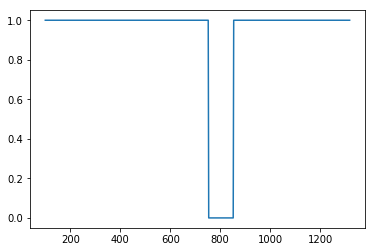

In [8]:
seizure_file = open(file_name_composer(patient_number, validation_number)
                    ,'r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
temp=[]
for row in reader:
    temp.append(row)
temp = np.array(temp)
nchannels = temp.shape[0]
ntimeseg = temp.shape[1]
onset = onset_times_ordered[patient_number-1][validation_number-1]
onset = np.array(onset)
validation_set = []
val_output = []
for i in range(ntimeseg-time_chunks):
    temp2 = [];
    initial_point = i;
    final_point = i+time_chunks
    for j in range(nchannels):
        temp2.append(temp[j][initial_point:final_point])
    
    output_temp = np.zeros(output_batch_size)
    index = output_batch_size - 1
        
    for j in range(len(onset)):
        onset_temp = onset[j]*ar_per_sec
        if initial_point<=onset_temp and final_point>onset_temp:
            index = 0
            break;
        value = onset_temp-final_point
        if value < 0 :
            break;
        temp_index = int(value/batch)+1;
        if temp_index < index:
            index = temp_index

    output_temp[index] = 1
    val_output.append(output_temp)
    validation_set.append(temp2)
    
validation_set = np.array(validation_set)
val_output = np.array(val_output)

print(validation_set.shape)
print(val_output.shape)

time = np.zeros(len(validation_set))
for j in range(len(validation_set)):
    time[j] = sec_per_ar*(j+time_chunks);
plt.plot(time,np.argmax(val_output,1))
plt.show()

In [9]:
x = tf.placeholder('float', [None, nchannels,time_chunks])
y = tf.placeholder('float')

In [10]:
def recurrent_neural_network(x):
    layer1 = {'weights':tf.Variable(0.01*tf.random_normal([rnn_size, hidden_layer1])),
            'biases':tf.Variable(0.01*tf.random_normal([hidden_layer1]))}
    layer2 = {'weights':tf.Variable(0.01*tf.random_normal([hidden_layer1, hidden_layer2])),
            'biases':tf.Variable(0.01*tf.random_normal([hidden_layer2]))}
    layer3 = {'weights':tf.Variable(0.01*tf.random_normal([hidden_layer2, hidden_layer3])),
            'biases':tf.Variable(0.01*tf.random_normal([hidden_layer3]))}
    layer4 = {'weights':tf.Variable(0.01*tf.random_normal([hidden_layer3, output_batch_size])),
            'biases':tf.Variable(0.01*tf.random_normal([output_batch_size]))}
    
    x = tf.transpose(x, [2,0,1])#crucial
    #x timechunks  none nchannels
    x = tf.reshape(x, [-1,nchannels])
    #x timechunks*none channels
    x = tf.split(0, time_chunks, x)
    #x timechunks  none*channels
    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size)
    #multi_cell = rnn_cell.MultiRNNCell([lstm_cell]*3)
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    #outputs time_chunks   none*rnn_size
    temp1 = tf.nn.relu(tf.matmul(outputs[-1],layer1['weights']) + layer1['biases'])
    #temp1 = tf.nn.relu(tf.matmul(outputs[-1],layer1['weights']) + layer1['biases'])
    temp2 = tf.nn.relu(tf.matmul(temp1,layer2['weights']) + layer2['biases'])
    temp3 = tf.nn.relu(tf.matmul(temp2,layer3['weights']) + layer3['biases'])
    output = tf.nn.softmax(tf.matmul(temp3,layer4['weights']) + layer4['biases'])

    return output

In [ ]:
prediction = recurrent_neural_network(x)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction,y))
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

prediction_state = tf.argmax(prediction,1)
output_state = tf.argmax(y,1)

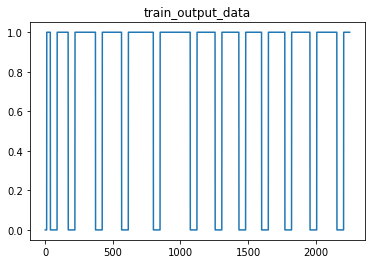

loss : 0.6916821002960205


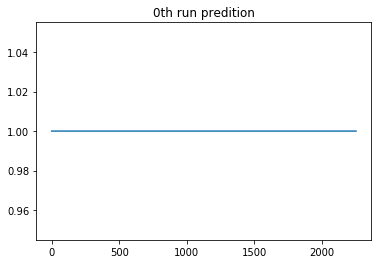

loss : 0.689169704914093
loss : 0.685796320438385
loss : 0.6752967834472656
loss : 0.6435644030570984
loss : 0.6065099239349365


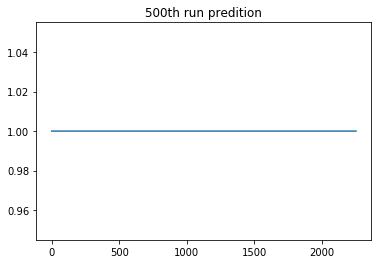

loss : 0.5917154550552368
loss : 0.587546169757843
loss : 0.5860859155654907
loss : 0.5854396224021912
loss : 0.585102379322052


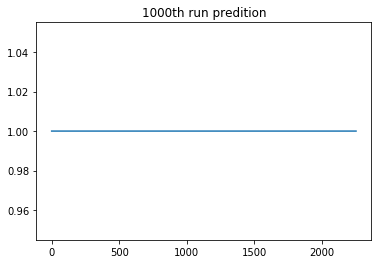

loss : 0.5849063992500305
loss : 0.5847823023796082


In [ ]:
plt.plot(np.argmax(output_data,1))
plt.title('train_output_data')
plt.show()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(5001):
    opt, c = sess.run([optimizer, cost], feed_dict={x: input_data, y: output_data})
    if i%100==0:
        print("loss : {}".format(c))
    if i%500==0:
        plt.plot(sess.run(prediction_state, feed_dict={x : input_data}))
        plt.title('{}th run predition'.format(i))
        plt.show()
           
plt.plot(time, sess.run(output_state, feed_dict={y : val_output}))
plt.title('validation_output')
plt.show()
plt.plot(time, sess.run(prediction_state, feed_dict={x : validation_set}))
plt.title("{}the patient {}th data".format(patient_number, validation_number))
plt.show()


In [ ]:
def validation_set_generator(vali_num):
    seizure_file = open(file_name_composer(patient_number, vali_num)
                        ,'r',newline='')
    reader = csv.reader(seizure_file,delimiter=',')
    temp=[]
    for row in reader:
        temp.append(row)
    temp = np.array(temp)
    nchannels = temp.shape[0]
    ntimeseg = temp.shape[1]
    onset = onset_times_ordered[patient_number-1][vali_num-1]
    onset = np.array(onset)
    validation_set = []
    val_output = []
    for i in range(ntimeseg-time_chunks):
        temp2 = [];
        initial_point = i;
        final_point = i+time_chunks
        for j in range(nchannels):
            temp2.append(temp[j][initial_point:final_point])

        output_temp = np.zeros(output_batch_size)
        index = output_batch_size - 1

        for j in range(len(onset)):
            onset_temp = onset[j]*ar_per_sec
            if initial_point<=onset_temp and final_point>onset_temp:
                index = 0
                break;
            value = onset_temp-final_point
            if value < 0 :
                break;
            temp_index = int(value/batch)+1;
            if temp_index < index:
                index = temp_index
        output_temp[index] = 1
        val_output.append(output_temp)
        validation_set.append(temp2)
    validation_set = np.array(validation_set)
    val_output = np.array(val_output)
    return {'input': validation_set,'output': val_output}
for i in range(1,event_number[patient_number-1]):
    result = validation_set_generator(i)
    validation_set = result['input']
    val_output = result['output']
    time = np.zeros(len(validation_set))
    for j in range(len(validation_set)):
        time[j] = sec_per_ar*(j+time_chunks);
    plt.plot(time,np.argmax(val_output,1))
    plt.title('{}th patient {}th data real'.format(patient_number, i))
    plt.show()
    plt.plot(time, sess.run(prediction_state, feed_dict={x : validation_set}))
    plt.title('{}th patient {}th data output'.format(patient_number, i))
    plt.show()


In [ ]:
"""
result = validation_set_generator(7)
input_data = result['input']
output_data = result['output']
plt.plot(np.argmax(output_data,1))
plt.title('output_data')
plt.show()
for i in range(30):
    opt, c = sess.run([optimizer, cost], feed_dict={x: input_data, y: output_data})
    if i%10==0:
        print("loss : {}".format(c))
    if i%10==0:
        plt.plot(sess.run(prediction_state, feed_dict={x : input_data}))
        plt.title('{}th run input_data'.format(i))
        plt.show()
"""